In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc, when, count as spark_count, concat_ws, length, rand, row_number
from pyspark.sql.window import Window
import pandas as pd

from pyspark.ml.feature import StringIndexer, RegexTokenizer, StopWordsRemover, Word2Vec
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

def measure_time(func, *args, **kwargs):
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()
    return result, end - start

measure_time

<function __main__.measure_time(func, *args, **kwargs)>

In [2]:
spark = SparkSession.builder \
    .appName("RAID_TRAIN_XLM-ROBERTA-NB") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

spark

In [3]:
df = spark.read.json("hdfs://namenode:8020/user/raid/raw")
df

DataFrame[attack: string, domain: string, features: array<double>, generation: string, id: string, model: string]

# Total Baris

In [4]:
print("Menghitung total jumlah baris...")
total_rows, time_0 = measure_time(lambda: df.count())
print(f"✅ Total baris: {total_rows:,} | Waktu: {time_0:.4f} detik")

Menghitung total jumlah baris...
✅ Total baris: 481,356 | Waktu: 4.8983 detik


# Filter

In [5]:
print("Memfilter data: length(generation) > 50...")
df_filtered, filter_time = measure_time(
    lambda: df.filter(length(col("generation")) > 50)
)

print(f"✅ Filter selesai dalam {filter_time:.2f} detik")

Memfilter data: length(generation) > 50...
✅ Filter selesai dalam 0.03 detik


In [6]:
df_filtered = df_filtered.repartition(128)
df_filtered

DataFrame[attack: string, domain: string, features: array<double>, generation: string, id: string, model: string]

# Split

In [7]:
print("[1] Menghitung total jumlah baris...")
total_rows, time_0 = measure_time(lambda: df_filtered.count())
print(f"✅ Total baris: {total_rows:,} | Waktu: {time_0:.4f} detik")

[1] Menghitung total jumlah baris...
✅ Total baris: 481,196 | Waktu: 5.9071 detik


In [8]:
print("[2] Membuat kolom stratifikasi 'model_domain_attack' ...")
df_with_strata, strat_time = measure_time(
    lambda: df_filtered.withColumn(
        "model_domain_attack",
        concat_ws("_", col("model"), col("domain"), col("attack"))
    )
)
print(f"✅ Kolom stratifikasi dibuat dalam {strat_time:.4f} detik")

[2] Membuat kolom stratifikasi 'model_domain_attack' ...
✅ Kolom stratifikasi dibuat dalam 0.0339 detik


In [9]:
df_with_strata = df_with_strata.repartition(128)
df_with_strata

DataFrame[attack: string, domain: string, features: array<double>, generation: string, id: string, model: string, model_domain_attack: string]

In [10]:
print("[3] Menghitung jumlah baris per 'model_domain_attack' ...")
df_counts, count_time = measure_time(
    lambda: df_with_strata.groupBy("model_domain_attack").agg(spark_count("*").alias("total_per_group"))
)
print(f"✅ Selesai dalam {count_time:.4f} detik")

[3] Menghitung jumlah baris per 'model_domain_attack' ...
✅ Selesai dalam 0.0322 detik


In [11]:
print("[4] Gabungkan count ke setiap baris")
df_joined, join_time = measure_time(
    lambda: df_with_strata.join(df_counts, on="model_domain_attack", how="inner")
)
print(f"✅ Data berhasil digabung dengan count per grup dalam {join_time:.4f} detik")

[4] Gabungkan count ke setiap baris
✅ Data berhasil digabung dengan count per grup dalam 0.0453 detik


In [12]:
print("[5] Memberi nomor urut acak dalam setiap grup ...")
window_spec = Window.partitionBy("model_domain_attack").orderBy(rand())
df_numbered, number_time = measure_time(
    lambda: df_joined.withColumn("row_num", row_number().over(window_spec))
)
print(f"✅ Penomoran selesai dalam {number_time:.4f} detik")

[5] Memberi nomor urut acak dalam setiap grup ...
✅ Penomoran selesai dalam 0.0252 detik


In [13]:
# [6] Tentukan batas 70% → masuk train jika row_num <= 0.7 * total_per_group
print("[6] Menentukan split berdasarkan 70% per grup ...")
df_with_split, split_time = measure_time(
    lambda: df_numbered.withColumn(
        "is_train",
        col("row_num") <= (col("total_per_group") * 0.7)
    )
)
print(f"✅ Split logic selesai dalam {split_time:.4f} detik")

[6] Menentukan split berdasarkan 70% per grup ...
✅ Split logic selesai dalam 0.0274 detik


In [14]:
# [7] Pisahkan train dan test
train_df = df_with_split.filter(col("is_train")).select(
    col("generation").alias("text"),
    col("model"),
    col("features")
)
test_df = df_with_split.filter(~col("is_train")).select(
    col("generation").alias("text"),
    col("model"),
    col("features")
)

train_count, train_count_time = measure_time(lambda: train_df.count())
test_count, test_count_time = measure_time(lambda: test_df.count())

print(f"✅ Train: {train_count:,} ({train_count_time:.4f} detik) | Test: {test_count:,} ({test_count_time:.4f} detik)")

✅ Train: 336,761 (8.8225 detik) | Test: 144,435 (6.7357 detik)


In [15]:
from pyspark.ml.functions import array_to_vector

train_df = train_df.withColumn("features", array_to_vector(col("features")))
test_df = test_df.withColumn("features", array_to_vector(col("features")))

# Opsional: cek tipe kolom
train_df.printSchema()

root
 |-- text: string (nullable = true)
 |-- model: string (nullable = true)
 |-- features: vector (nullable = true)



# Train

In [18]:
from pyspark.ml.feature import StringIndexer, RegexTokenizer, StopWordsRemover, Word2Vec
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

train_df, test_df

(DataFrame[text: string, model: string, features: vector],
 DataFrame[text: string, model: string, features: vector])

In [21]:
# === Pipeline: StringIndexer + LogisticRegression ===
print("Membangun pipeline...")

# StringIndexer untuk label 'model'
string_indexer = StringIndexer(
    inputCol="model",
    outputCol="label",
    handleInvalid="error"
)

nb = NaiveBayes(
    featuresCol="features",
    labelCol="label",
    modelType="gaussian",
    smoothing=1.0
)

pipeline = Pipeline(stages=[string_indexer, nb])
pipeline

Membangun pipeline...


Pipeline_43e9c9c72323

In [22]:
# --- 3. Latih model ---
print("[14] Melatih model pada train_df...")
model, train_model_time = measure_time(
    lambda: pipeline.fit(train_df)
)
print(f"✅ Model berhasil dilatih dalam {train_model_time:.4f} detik")

[14] Melatih model pada train_df...
✅ Model berhasil dilatih dalam 64.2956 detik


In [23]:
# --- 4. Simpan model ke HDFS ---
model_path = "hdfs://namenode:8020/user/raid/model-xlmroberta-nb"
print(f"[15] Menyimpan model ke HDFS: {model_path}...")
_, save_time = measure_time(
    lambda: model.write().overwrite().save(model_path)
)
print(f"✅ Model disimpan dalam {save_time:.4f} detik")

[15] Menyimpan model ke HDFS: hdfs://namenode:8020/user/raid/model-xlmroberta-nb...
✅ Model disimpan dalam 3.5219 detik


In [24]:
# --- 5. Prediksi pada test set ---
print("[16] Melakukan prediksi pada test_df...")
predictions, predict_time = measure_time(
    lambda: model.transform(test_df)
)
print(f"✅ Prediksi selesai dalam {predict_time:.4f} detik")

# Tampilkan contoh
predictions.select("text", "model", "label", "prediction", "probability").show(5, truncate=50)

[16] Melakukan prediksi pada test_df...
✅ Prediksi selesai dalam 0.0451 detik
+--------------------------------------------------+-----+-----+----------+------------------------------------------+
|                                              text|model|label|prediction|                               probability|
+--------------------------------------------------+-----+-----+----------+------------------------------------------+
|Judges at the US Supreme Court have been hearin...|human|  1.0|       0.0| [0.9999669917856433,3.300821435662843E-5]|
|Arsenal manager Arsene Wenger has admitted he i...|human|  1.0|       1.0|[8.204669754669169E-12,0.9999999999917952]|
|Talks on Russia's proposed membership of the Wo...|human|  1.0|       1.0| [1.684537949634615E-5,0.9999831546205037]|
|Nintendo's new handheld console, the DS, will l...|human|  1.0|       1.0|   [0.3385647930114429,0.6614352069885572]|
|The Conservative Party would cut the number of ...|human|  1.0|       1.0|[9.28411928150

In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# --- 6. Evaluasi berbagai metrik ---
print("[17] Evaluasi...")

# Accuracy
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy, time_acc = measure_time(lambda: evaluator_acc.evaluate(predictions))

# Weighted Precision
evaluator_prec = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision, time_prec = measure_time(lambda: evaluator_prec.evaluate(predictions))

# Weighted Recall
evaluator_rec = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall, time_rec = measure_time(lambda: evaluator_rec.evaluate(predictions))

# F1-score (weighted)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)
f1_score, time_f1 = measure_time(lambda: evaluator_f1.evaluate(predictions))

# Tampilkan hasil
print(f"✅ Accuracy    : {accuracy:.4f} | Waktu: {time_acc:.4f} detik")
print(f"✅ Precision   : {precision:.4f} | Waktu: {time_prec:.4f} detik")
print(f"✅ Recall      : {recall:.4f} | Waktu: {time_rec:.4f} detik")
print(f"✅ F1-score    : {f1_score:.4f} | Waktu: {time_f1:.4f} detik")

[17] Evaluasi...
✅ Accuracy    : 0.8124 | Waktu: 35.3130 detik
✅ Precision   : 0.8449 | Waktu: 34.9178 detik
✅ Recall      : 0.8130 | Waktu: 56.6303 detik
✅ F1-score    : 0.8180 | Waktu: 87.5011 detik


In [26]:
print("[18] Membuat confusion matrix dengan label string...")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Ambil hasil prediksi ke Pandas
pred_pd, time_pred_pd = measure_time(lambda: predictions.select("model", "label", "prediction").toPandas())
print(f'✅ Selesai dalam {time_pred_pd:.4f} detik')
pred_pd

[18] Membuat confusion matrix dengan label string...
✅ Selesai dalam 147.1031 detik


,model,label,prediction
0,human,1.0,0.0
1,human,1.0,1.0
2,human,1.0,1.0
3,human,1.0,1.0
4,human,1.0,1.0
...,...,...,...
144430,human,1.0,1.0
144431,human,1.0,1.0
144432,human,1.0,1.0
144433,human,1.0,1.0


In [27]:
# Buat mapping label numerik ke string (gunakan data unik dari hasil prediksi)
label_map = (
    pred_pd[["label", "model"]]
    .drop_duplicates()
    .sort_values("label")
    .set_index("label")["model"]
    .to_dict()
)
label_map

{0.0: 'gpt4', 1.0: 'human'}

In [28]:
pred_pd["true_label"] = pred_pd["label"].map(label_map)
pred_pd["pred_label"] = pred_pd["prediction"].map(label_map)
pred_pd

,model,label,prediction,true_label,pred_label
0,human,1.0,0.0,human,gpt4
1,human,1.0,1.0,human,human
2,human,1.0,1.0,human,human
3,human,1.0,1.0,human,human
4,human,1.0,1.0,human,human
...,...,...,...,...,...
144430,human,1.0,1.0,human,human
144431,human,1.0,1.0,human,human
144432,human,1.0,1.0,human,human
144433,human,1.0,1.0,human,human


In [29]:
results_path = "hdfs://namenode:8020/user/raid/xlmroberta-nb_results.parquet"
print(f"Menyimpan hasil ke HDFS: {results_path}...")
_, save_time = measure_time(
    lambda: predictions.select("model", "label", "prediction") \
        .write.mode("overwrite") \
        .parquet(results_path)
)
print(f"✅ Hasil disimpan dalam {save_time:.4f} detik")

Menyimpan hasil ke HDFS: hdfs://namenode:8020/user/raid/xlmroberta-nb_results.parquet...
✅ Hasil disimpan dalam 114.8608 detik


In [30]:
# Ambil hanya label yang muncul di data
unique_labels = sorted(list(set(pred_pd["true_label"]) | set(pred_pd["pred_label"])))
len(unique_labels)

2

In [31]:
unique_labels

['gpt4', 'human']

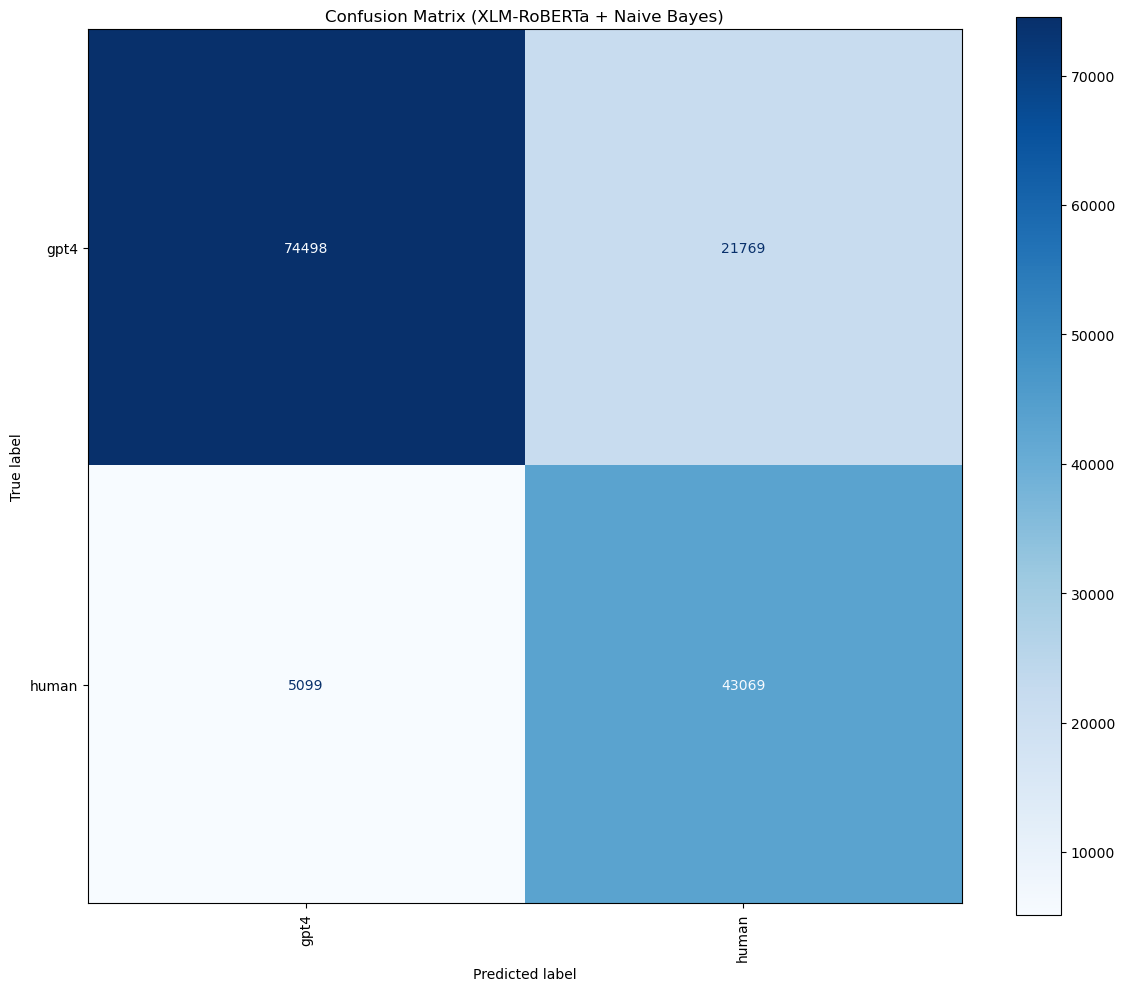

In [32]:
# Buat confusion matrix
cm = confusion_matrix(pred_pd["true_label"], pred_pd["pred_label"], labels=unique_labels)

# Visualisasi
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(ax=ax, cmap="Blues", colorbar=True, xticks_rotation=90)

# Timpa teks lama dengan nilai dari cm secara langsung
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        disp.text_[i, j].set_text(f"{cm[i, j]}")  # atau tanpa koma: f"{cm[i, j]}"

plt.title("Confusion Matrix (XLM-RoBERTa + Naive Bayes)")
plt.tight_layout()
plt.show()

In [32]:
spark.stop()